# Trial with full 40-rag Dataset

In [1]:
%cd /home/teamdaedulus/

/home/teamdaedulus


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 
# input_size = 128
# hidden_size = 768
# num_layers = 1
# num_classes = 40


In [4]:
X_train = torch.from_numpy(np.load("data/X_train40.npy")).long()
Y_train = torch.from_numpy(np.load("data/Y_train40.npy")).long()
print(f"Training data: X - {X_train.shape}, Y - {Y_train.shape}")

Training data: X - torch.Size([72000, 5000]), Y - torch.Size([72000])


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.set_device(1)
device

device(type='cuda')

In [3]:
torch.cuda.empty_cache()

In [4]:
# Code inspired from the following blog post
# https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)        
        self.supports_masking = True
        
        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

In [5]:
class Model(nn.Module):
    def __init__(self, input_length=5000, embedding_size=128, hidden_size=768,
                num_layers=1, num_classes=40, vocab_size=209, drop_prob=0.5):
      super(Model, self).__init__()
      self.num_layers = num_layers
      self.hidden_size = hidden_size
      self.fc1 = nn.Linear(hidden_size, 384)
      self.fc2 = nn.Linear(384, num_classes)
      # self.batchNorm1d = nn.BatchNorm1d(input_length)
      self.dropout = nn.Dropout(0.3)
      self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers,
                          dropout=drop_prob, batch_first=True)
      self.embeddings = nn.Embedding(vocab_size, embedding_size)
      self.attention_layer = Attention(hidden_size, input_length)
      self.relu = nn.ReLU()

    def forward(self, x):
      batch_size = x.size(0)
      embeds = self.embeddings(x)
      # print("embeds ", embeds.shape)
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
      out, _ = self.lstm(embeds, (h0, c0)) #We don't need the hidden tensor
      # print("lstm ", out.shape)
      # out = self.batchNorm1d(out)
      out = self.attention_layer(out)
      # print("attention ", out.shape)
     
      out = self.relu(self.fc1(out))
      # print("fc1 ", out.shape)
      out = self.dropout(out)
      out = self.fc2(out)
      # print("output ", out.shape)

      return out

In [9]:
model = Model().to(device)
# transfer weights of the 10rag dataset model
pretrained_dict = torch.load("lstm_30_model.pth")
model_dict = model.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k not in ['fc2.bias', 'fc2.weight']}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(model_dict)

/opt/anaconda3/envs/pipenv/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


<All keys matched successfully>

In [10]:
# Reloading saved model

model = Model().to(device)
model.load_state_dict(torch.load("models40/lstm_25_checkpoint.pth"))

<All keys matched successfully>

In [10]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 40
trainset = TensorDataset(X_train, Y_train)
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)

In [11]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = Adam(model.parameters(), lr=0.0001)

In [12]:
len(trainloader)

1800

In [ ]:
# training the model
model.train()
losslist = []
for epoch in range(15):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'Epoch: {epoch+1} | Batches Done: {i+1}/1800 | Loss: {(running_loss/100):.3f}')
            epoch_loss += running_loss
            running_loss = 0.0
    losslist.append(epoch_loss/1800)
    print("="*50)
    print(f"EPOCH {epoch+1} OVERALL LOSS: {losslist[-1]:.3f}")
    print("="*50)
    if epoch % 5 == 4:
        path = f"models40/lstm_{epoch+1}_checkpoint.pth"
        print(f"Saving model weights at Epoch {epoch+1} ...")
        torch.save(model.state_dict(), path)
print("Finished Training!")

Epoch: 1 | Batches Done: 100/1800 | Loss: 3.416
Epoch: 1 | Batches Done: 200/1800 | Loss: 2.779
Epoch: 1 | Batches Done: 300/1800 | Loss: 2.425
Epoch: 1 | Batches Done: 400/1800 | Loss: 2.208
Epoch: 1 | Batches Done: 500/1800 | Loss: 2.200
Epoch: 1 | Batches Done: 600/1800 | Loss: 2.010
Epoch: 1 | Batches Done: 700/1800 | Loss: 1.915
Epoch: 1 | Batches Done: 800/1800 | Loss: 1.785
Epoch: 1 | Batches Done: 900/1800 | Loss: 1.823
Epoch: 1 | Batches Done: 1000/1800 | Loss: 1.735
Epoch: 1 | Batches Done: 1100/1800 | Loss: 1.636
Epoch: 1 | Batches Done: 1200/1800 | Loss: 1.583
Epoch: 1 | Batches Done: 1300/1800 | Loss: 1.515
Epoch: 1 | Batches Done: 1400/1800 | Loss: 1.529
Epoch: 1 | Batches Done: 1500/1800 | Loss: 1.603
Epoch: 1 | Batches Done: 1600/1800 | Loss: 1.459
Epoch: 1 | Batches Done: 1700/1800 | Loss: 1.428
Epoch: 1 | Batches Done: 1800/1800 | Loss: 1.436
EPOCH 1 OVERALL LOSS: 1.916
Epoch: 2 | Batches Done: 100/1800 | Loss: 1.380
Epoch: 2 | Batches Done: 200/1800 | Loss: 1.328
Epo

Epoch: 9 | Batches Done: 400/1800 | Loss: 0.504
Epoch: 9 | Batches Done: 500/1800 | Loss: 0.505
Epoch: 9 | Batches Done: 600/1800 | Loss: 0.546
Epoch: 9 | Batches Done: 700/1800 | Loss: 0.521
Epoch: 9 | Batches Done: 800/1800 | Loss: 0.483
Epoch: 9 | Batches Done: 900/1800 | Loss: 0.513
Epoch: 9 | Batches Done: 1000/1800 | Loss: 0.479
Epoch: 9 | Batches Done: 1100/1800 | Loss: 0.518
Epoch: 9 | Batches Done: 1200/1800 | Loss: 0.511
Epoch: 9 | Batches Done: 1300/1800 | Loss: 0.512
Epoch: 9 | Batches Done: 1400/1800 | Loss: 0.491
Epoch: 9 | Batches Done: 1500/1800 | Loss: 0.479
Epoch: 9 | Batches Done: 1600/1800 | Loss: 0.465
Epoch: 9 | Batches Done: 1700/1800 | Loss: 0.513
Epoch: 9 | Batches Done: 1800/1800 | Loss: 0.501
EPOCH 9 OVERALL LOSS: 0.504
Epoch: 10 | Batches Done: 100/1800 | Loss: 0.518
Epoch: 10 | Batches Done: 200/1800 | Loss: 0.561
Epoch: 10 | Batches Done: 300/1800 | Loss: 0.510
Epoch: 10 | Batches Done: 400/1800 | Loss: 0.476
Epoch: 10 | Batches Done: 500/1800 | Loss: 0.46

In [ ]:
# Continue training
# training the model
model.train()
losslist = []
for epoch in range(10, 31):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'Epoch: {epoch+1} | Batches Done: {i+1}/1800 | Loss: {(running_loss/100):.3f}')
            epoch_loss += running_loss
            running_loss = 0.0
    losslist.append(epoch_loss/1800)
    print("="*50)
    print(f"EPOCH {epoch+1} OVERALL LOSS: {losslist[-1]:.3f}")
    print("="*50)
    if epoch % 5 == 4:
        path = f"models40/lstm_{epoch+1}_checkpoint.pth"
        print(f"Saving model weights at Epoch {epoch+1} ...")
        torch.save(model.state_dict(), path)
print("Finished Training!")

Epoch: 11 | Batches Done: 100/1800 | Loss: 0.424
Epoch: 11 | Batches Done: 200/1800 | Loss: 0.430
Epoch: 11 | Batches Done: 300/1800 | Loss: 0.410
Epoch: 11 | Batches Done: 400/1800 | Loss: 0.402
Epoch: 11 | Batches Done: 500/1800 | Loss: 0.452
Epoch: 11 | Batches Done: 600/1800 | Loss: 0.421
Epoch: 11 | Batches Done: 700/1800 | Loss: 0.408
Epoch: 11 | Batches Done: 800/1800 | Loss: 0.404
Epoch: 11 | Batches Done: 900/1800 | Loss: 0.426
Epoch: 11 | Batches Done: 1000/1800 | Loss: 0.434
Epoch: 11 | Batches Done: 1100/1800 | Loss: 0.415
Epoch: 11 | Batches Done: 1200/1800 | Loss: 0.421
Epoch: 11 | Batches Done: 1300/1800 | Loss: 0.451
Epoch: 11 | Batches Done: 1400/1800 | Loss: 0.436
Epoch: 11 | Batches Done: 1500/1800 | Loss: 0.395
Epoch: 11 | Batches Done: 1600/1800 | Loss: 0.380
Epoch: 11 | Batches Done: 1700/1800 | Loss: 0.393
Epoch: 11 | Batches Done: 1800/1800 | Loss: 0.459
EPOCH 11 OVERALL LOSS: 0.420
Epoch: 12 | Batches Done: 100/1800 | Loss: 0.380
Epoch: 12 | Batches Done: 200/1

Epoch: 19 | Batches Done: 100/1800 | Loss: 0.201
Epoch: 19 | Batches Done: 200/1800 | Loss: 0.222
Epoch: 19 | Batches Done: 300/1800 | Loss: 0.235
Epoch: 19 | Batches Done: 400/1800 | Loss: 0.215
Epoch: 19 | Batches Done: 500/1800 | Loss: 0.225
Epoch: 19 | Batches Done: 600/1800 | Loss: 0.268
Epoch: 19 | Batches Done: 700/1800 | Loss: 0.252
Epoch: 19 | Batches Done: 800/1800 | Loss: 0.234
Epoch: 19 | Batches Done: 900/1800 | Loss: 0.230
Epoch: 19 | Batches Done: 1000/1800 | Loss: 0.245


In [8]:
# Plot loss curve

data = open("40_losslist_lstm.txt").read().strip().split("\n")
data = np.array(list(map(lambda x: eval(x.split()[-1]), data)))

In [10]:
234//18

13

In [11]:
losslist=[]
for i in range(13):
    start = i*18
    epoch_data = np.mean(data[start:start+18])
    losslist.append(epoch_data)
losslist = np.array(losslist)
np.save("40_lstm_losslist.npy", losslist)

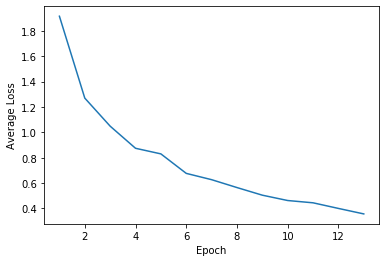

In [16]:
losslist = np.load("40_lstm_losslist.npy")
plt.plot(list(np.arange(1,len(losslist)+1)), losslist)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.savefig("plots/40_lstm_loss_plot.png")
plt.show()

In [11]:
# load test datasets 

X_test = torch.from_numpy(np.load("data/X_test40.npy")).long()
Y_test = torch.from_numpy(np.load("data/Y_test40.npy")).long()
print(f"Training data: X - {X_test.shape}, Y - {Y_test.shape}")

Training data: X - torch.Size([24000, 5000]), Y - torch.Size([24000])


In [12]:
def evaluate_sample(preds, labels, threshold):
    matched = float(torch.sum(preds==labels))
    if matched/len(preds) >= threshold:
        return True
    return False

def evaluate(net, X_test, Y_test, verbose=False, threshold=0.6):
    net.eval()
    N = len(Y_test)//200 # no of music samples in test set
    correct = 0
    for i in range(N):
        start = i*200
        with torch.no_grad():
            out = net.forward(X_test[start:start+200].to(device))
        preds = torch.argmax(out, axis=-1)
        labels = Y_test[start:start+200].to(device)
        if evaluate_sample(preds, labels, threshold):
            correct+=1
            if verbose:
                print(f"Sample {i+1}/{N} classified as CORRECT")
        elif verbose:
            print(f"Sample {i+1}/{N} classified as INCORRECT")    

    accuracy = correct/N
    print("="*50)
    print(f"Accuracy of the model on {N} unseen music samples: {(accuracy*100):.2f}%")
    print("="*50)

In [14]:
# model.load_state_dict(torch.load("lstm_30_model.pth"))

<All keys matched successfully>

In [13]:
evaluate(model, X_test, Y_test, threshold=0.6, verbose=True)

Sample 1/120 classified as CORRECT
Sample 2/120 classified as CORRECT
Sample 3/120 classified as CORRECT
Sample 4/120 classified as CORRECT
Sample 5/120 classified as INCORRECT
Sample 6/120 classified as CORRECT
Sample 7/120 classified as INCORRECT
Sample 8/120 classified as INCORRECT
Sample 9/120 classified as INCORRECT
Sample 10/120 classified as INCORRECT
Sample 11/120 classified as CORRECT
Sample 12/120 classified as INCORRECT
Sample 13/120 classified as CORRECT
Sample 14/120 classified as CORRECT
Sample 15/120 classified as CORRECT
Sample 16/120 classified as CORRECT
Sample 17/120 classified as CORRECT
Sample 18/120 classified as CORRECT
Sample 19/120 classified as CORRECT
Sample 20/120 classified as CORRECT
Sample 21/120 classified as CORRECT
Sample 22/120 classified as CORRECT
Sample 23/120 classified as CORRECT
Sample 24/120 classified as CORRECT
Sample 25/120 classified as CORRECT
Sample 26/120 classified as CORRECT
Sample 27/120 classified as CORRECT
Sample 28/120 classified 

In [14]:
evaluate(model, X_test, Y_test, threshold=0.5)

Accuracy of the model on 120 unseen music samples: 75.00%


In [22]:
def evaluate_naive(net, X_test, Y_test):
    net.eval()
    N = len(Y_test)//200 # no of music samples in test set
    correct = 0
    for i in range(N):
        start = i*200
        with torch.no_grad():
            out = net.forward(X_test[start:start+200].to(device))
        preds = torch.argmax(out, axis=-1)
        labels = Y_test[start:start+200].to(device)
        correct += torch.sum(preds==labels)
        
    accuracy = float(correct)/len(Y_test)
    print("="*50)
    print(f"Accuracy on given data: {(accuracy*100):.2f}%")
    print("="*50)

In [19]:
evaluate_naive(net, X_train, Y_train)

Accuracy on given data: 98.61%


In [24]:
evaluate_naive(model, X_test, Y_test)

Accuracy on given data: 64.75%


In [35]:
np.save("lstm_losslist.npy", losslist)

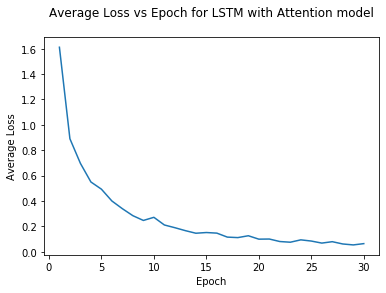

In [36]:
losslist = np.load("lstm_losslist.npy")
plt.plot(list(np.arange(1,len(losslist)+1)), losslist)
plt.title("Average Loss vs Epoch for LSTM with Attention model\n")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.savefig("plots/lstm_loss_plot.png")
plt.show()